In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 18 16:06:29 2019

@author: mor
"""

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix , precision_recall_curve
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score , roc_auc_score , average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [3]:


filenames=glob.glob('data\\chapter_2\\*.csv')
filenames = sorted(filenames)
df = pd.read_csv(filenames[-1])

X=df.drop(['V1','Class'],axis=1).values
y=df.Class.values


In [4]:


# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)



95.8904109589041


In [5]:


# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(n_estimators=10 ,random_state=5)



In [6]:


# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))



0.9904109589041096


In [7]:


# Import the packages to get the different performance metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))



0.9338879319822626
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.96      0.80      0.87        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.98      0.90      0.93      2190
weighted avg       0.99      0.99      0.99      2190

[[2096    3]
 [  18   73]]


In [8]:


def plot_pr_curve(recall, precision, average_precision):
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  plt.show()



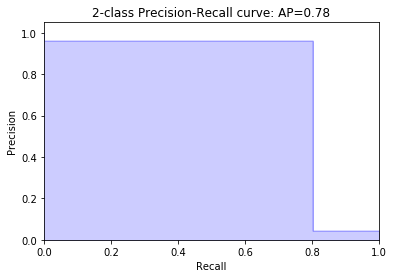

In [9]:


# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)



In [10]:


# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample',n_estimators=10 , random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))



0.9347962661445273
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.79      0.88        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2098    1]
 [  19   72]]


In [11]:

def check_proba_valid(model):
    if type(model).__name__=='VotingClassifier' and model.voting=='hard':
        return False
    return True

def get_model_results(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  
  if check_proba_valid(model):
      probs = model.predict_proba(X_test)
      print('\n\n')
      print(roc_auc_score(y_test, probs[:,1]))
  print (classification_report(y_test, predicted))
  print (confusion_matrix(y_test, predicted))
  



In [12]:


# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',
			
			# Change depth of model
            max_depth=10,
		
			# Change the number of samples in leaf nodes
            min_samples_leaf=10, 

			# Change the number of trees to use
            n_estimators=20, n_jobs=-1, random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)






0.9609651901219315
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.85      0.91        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2097    2]
 [  14   77]]


In [13]:


# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 'max_features': ['auto', 'log2'],  'max_depth': [4, 8], 'criterion': ['gini', 'entropy']
}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_



{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

In [14]:


# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini',
            max_depth=8, max_features='log2',  min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)






0.9749697658225529
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2095    4]
 [  15   76]]


In [15]:


# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)






0.9722054981702433
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.63      0.88      0.73        91

   micro avg       0.97      0.97      0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190

[[2052   47]
 [  11   80]]


In [16]:


# Import the package
from sklearn.ensemble import VotingClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)



              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2090    9]
 [  13   78]]


In [17]:


# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)







0.9739279300975348
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.85      0.89        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2094    5]
 [  14   77]]
